---
## Init
---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import scipy.linalg

# Configuration
D = 64          # Input dimension
N_TRAIN = 200   # Training samples
N_TEST = 1000   # Test samples
NOISE_RATE = 0.2 # Label noise
EPSILON = 0.5   # Adversarial perturbation magnitude
PGD_STEPS = 10  # Steps for attack
PGD_ALPHA = 0.1 # Step size

---
## Data
---

In [ ]:
def generate_data(n, d, sigma_scale=1.0, noise=0.0):
    # Anisotropic covariance (Section 4.4 validation)
    # cov = diag(1, 1/2, 1/3...) to create variance disparity
    cov = np.diag([sigma_scale**(i/d) for i in range(d)]) # Decaying variance
    X = np.random.multivariate_normal(np.zeros(d), cov, n)

    # True signal: Beta aligned with first dimension
    beta = np.zeros(d)
    beta[0] = 1.0

    y = np.sign(X @ beta)

    # Add label noise
    flip = np.random.rand(n) < noise
    y[flip] *= -1
    return X, y

---
## Training Functions
---

In [ ]:
def get_random_features(X, W):
    # W: (N_features, d)
    # X: (n, d)
    # Output: (n, N_features) scaled by 1/sqrt(N)
    N = W.shape[0]
    Z = np.maximum(0, X @ W.T) # ReLU
    return Z / np.sqrt(N)


def train_ridge(Phi, y, lam=1e-8):
    # Closed form: theta = (Phi.T Phi + lam I)^-1 Phi.T y
    # Efficient solve using Cholesky or standard solve
    n, N = Phi.shape
    # If N > n (Overparametrized), use dual form (Kernel) for speed/stability
    # Dual: theta = Phi.T (Phi Phi.T + lam I)^-1 y
    if N > n:
        K = Phi @ Phi.T
        alpha = scipy.linalg.solve(K + lam * np.eye(n), y, assume_a='pos')
        theta = Phi.T @ alpha
    else:
        Cov = Phi.T @ Phi
        theta = scipy.linalg.solve(Cov + lam * np.eye(N), Phi.T @ y, assume_a='pos')
    return theta

def train_generative(Phi, y):
    # Nearest Centroid
    # theta = mu_+ - mu_-
    pos_mask = (y == 1)
    neg_mask = (y == -1)

    if np.sum(pos_mask) == 0 or np.sum(neg_mask) == 0:
        return np.zeros(Phi.shape[1]) # Fallback

    mu_pos = np.mean(Phi[pos_mask], axis=0)
    mu_neg = np.mean(Phi[neg_mask], axis=0)
    theta = mu_pos - mu_neg
    return theta

---
## PGD Attack
---

In [ ]:
def pgd_attack(model_theta, W, X, y, epsilon, alpha, steps):
    # Gradient of f(x) w.r.t x for f(x) = theta.T * ReLU(Wx)/sqrt(N)
    # Grad_x = (1/sqrt(N)) * W.T * diag(step(Wx)) * theta
    N = W.shape[0]
    X_adv = X.copy()

    for _ in range(steps):
        # Forward pass features
        Z_pre = X_adv @ W.T

        # Compute gradient
        # Indicator of ReLU activation (n, N)
        activations = (Z_pre > 0).astype(float)

        # Backprop to inputs: (n, d)
        # Element-wise multiply activations with theta, then project back via W
        grad_x = (activations * model_theta) @ W
        grad_x = grad_x / np.sqrt(N)

        # Ascent step (maximize loss -> minimize margin y * f(x))
        # We want to minimize y * f(x), so we move x in direction -y * grad

        step_dir = -y[:, None] * np.sign(grad_x)
        X_adv = X_adv + alpha * step_dir

        # Projection
        delta = X_adv - X
        delta = np.clip(delta, -epsilon, epsilon) # L_inf projection (easier) or normalize for L2

        # For L2 projection (match paper):
        norms = np.linalg.norm(delta, axis=1, keepdims=True)
        # Avoid division by zero
        norms[norms < 1e-10] = 1.0
        factor = np.minimum(1, epsilon / norms)
        delta = delta * factor

        X_adv = X + delta

    return X_adv

---
# Main
---

In [ ]:
X_train, y_train = generate_data(N_TRAIN, D, noise=NOISE_RATE)
X_test, y_test = generate_data(N_TEST, D, noise=0.0) # Evaluate on clean ground truth

N_values = np.linspace(10, 2000, 10).astype(int) # Overparametrization Sweep
results = {'N': N_values,
           'acc_A': [], 'rob_A': [], 'norm_A': [],
           'acc_B': [], 'rob_B': [], 'norm_B': []}

for N in N_values:
    # 1. Initialize random features
    W = np.random.randn(N, D)

    Phi_train = get_random_features(X_train, W)
    Phi_test = get_random_features(X_test, W)

    # 2. Train Model A (Discriminative - Ridgeless)
    theta_A = train_ridge(Phi_train, y_train, lam=1e-6)

    # 3. Train Model B (Generative)
    theta_B = train_generative(Phi_train, y_train)

    # 4. Metrics Model A
    # Standard
    preds_A = np.sign(Phi_test @ theta_A)
    acc_A = accuracy_score(y_test, preds_A)
    # Robust (PGD)
    X_adv_A = pgd_attack(theta_A, W, X_test, y_test, EPSILON, PGD_ALPHA, PGD_STEPS)
    Phi_adv_A = get_random_features(X_adv_A, W)
    rob_A = accuracy_score(y_test, np.sign(Phi_adv_A @ theta_A))

    # 5. Metrics Model B
    # Standard
    preds_B = np.sign(Phi_test @ theta_B)
    acc_B = accuracy_score(y_test, preds_B)
    # Robust (PGD)
    X_adv_B = pgd_attack(theta_B, W, X_test, y_test, EPSILON, PGD_ALPHA, PGD_STEPS)
    Phi_adv_B = get_random_features(X_adv_B, W)
    rob_B = accuracy_score(y_test, np.sign(Phi_adv_B @ theta_B))

    # Store
    results['acc_A'].append(acc_A)
    results['rob_A'].append(rob_A)
    results['norm_A'].append(np.linalg.norm(theta_A))

    results['acc_B'].append(acc_B)
    results['rob_B'].append(rob_B)
    results['norm_B'].append(np.linalg.norm(theta_B))

    print(f"N={N}: Norm A={results['norm_A'][-1]:.2f}, Norm B={results['norm_B'][-1]:.2f}")


N=10: Norm A=0.17, Norm B=0.72
N=231: Norm A=13.12, Norm B=0.82
N=452: Norm A=6.22, Norm B=0.86
N=673: Norm A=6.26, Norm B=0.78
N=894: Norm A=5.44, Norm B=0.81
N=1115: Norm A=5.19, Norm B=0.82
N=1336: Norm A=5.41, Norm B=0.82
N=1557: Norm A=5.18, Norm B=0.80
N=1778: Norm A=5.20, Norm B=0.81
N=2000: Norm A=5.21, Norm B=0.81


<>:265: SyntaxWarning: invalid escape sequence '\|'
<>:279: SyntaxWarning: invalid escape sequence '\l'
<>:314: SyntaxWarning: invalid escape sequence '\e'
<>:265: SyntaxWarning: invalid escape sequence '\|'
<>:279: SyntaxWarning: invalid escape sequence '\l'
<>:314: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-292575513.py:265: SyntaxWarning: invalid escape sequence '\|'
  ax2.set_ylabel('Weight Norm $\|\Theta\|_2$', rotation=270, labelpad=20)
/tmp/ipython-input-292575513.py:279: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(g_B['Acc_A'], g_B['Rob_A'], color=COLOR_DISC_MAIN, marker='o', label='Discriminative (Varying $\lambda$)')
/tmp/ipython-input-292575513.py:314: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('Label Noise Rate ($\eta$)')


--- Running exp_A_curse ---
Total Configs: 200 | Already Done: 0
Done: N=63, Seed=0 -> RobA=0.64, RobB=0.61
Done: N=63, Seed=1 -> RobA=0.66, RobB=0.64
Done: N=63, Seed=2 -> RobA=0.61, RobB=0.56
Done: N=63, Seed=3 -> RobA=0.65, RobB=0.61
Done: N=63, Seed=4 -> RobA=0.59, RobB=0.52
Done: N=63, Seed=5 -> RobA=0.64, RobB=0.62
Done: N=63, Seed=6 -> RobA=0.60, RobB=0.62
Done: N=63, Seed=7 -> RobA=0.61, RobB=0.60
Done: N=63, Seed=8 -> RobA=0.58, RobB=0.55
Done: N=63, Seed=9 -> RobA=0.55, RobB=0.54
Done: N=76, Seed=0 -> RobA=0.64, RobB=0.61
Done: N=76, Seed=1 -> RobA=0.64, RobB=0.65
Done: N=76, Seed=2 -> RobA=0.59, RobB=0.56
Done: N=76, Seed=3 -> RobA=0.68, RobB=0.62
Done: N=76, Seed=4 -> RobA=0.59, RobB=0.52
Done: N=76, Seed=5 -> RobA=0.68, RobB=0.64
Done: N=76, Seed=6 -> RobA=0.60, RobB=0.64
Done: N=76, Seed=7 -> RobA=0.64, RobB=0.61
Done: N=76, Seed=8 -> RobA=0.59, RobB=0.55
Done: N=76, Seed=9 -> RobA=0.56, RobB=0.54
Done: N=91, Seed=0 -> RobA=0.66, RobB=0.61
Done: N=91, Seed=1 -> RobA=0.65,

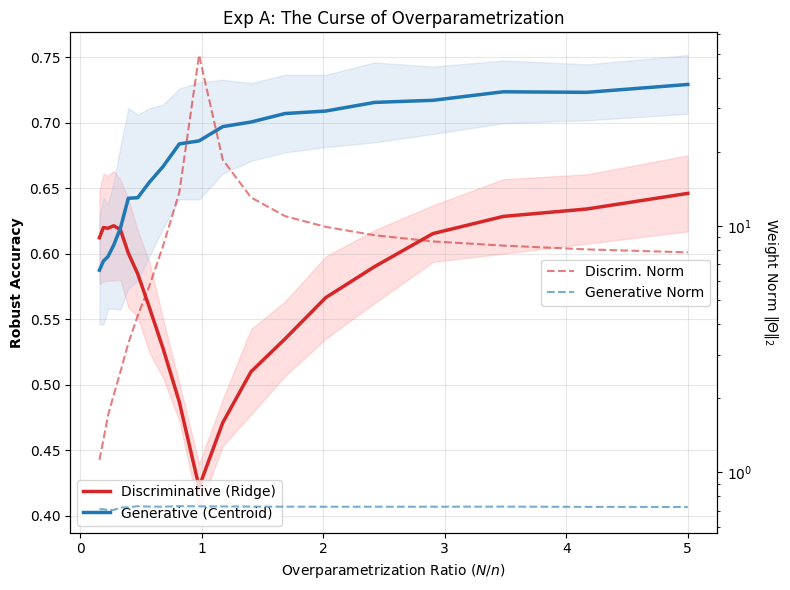

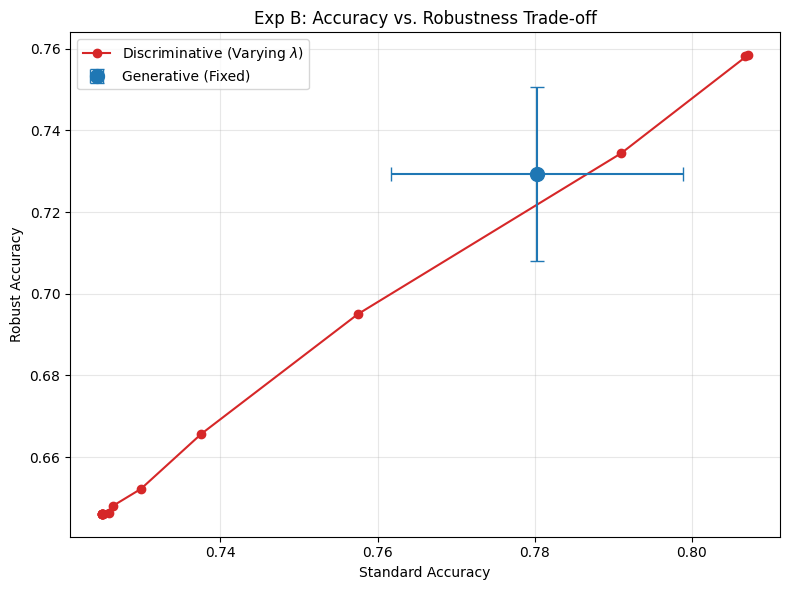

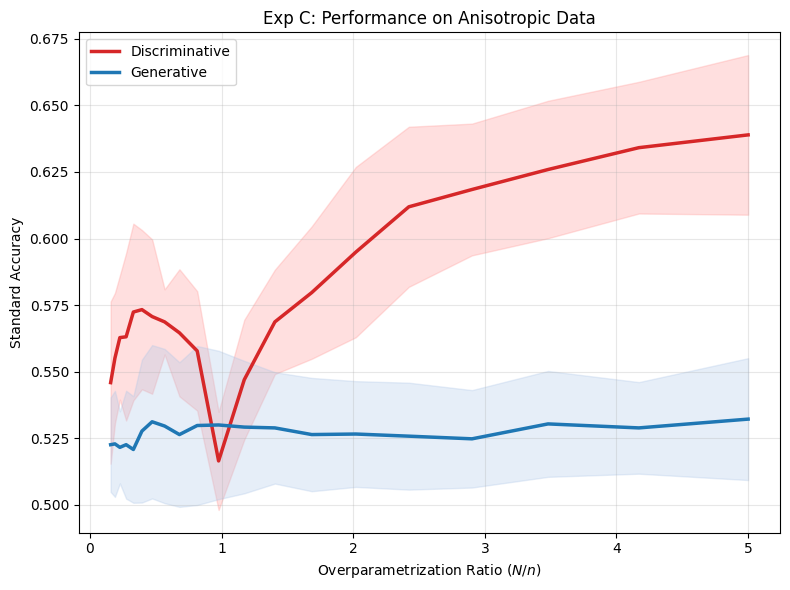

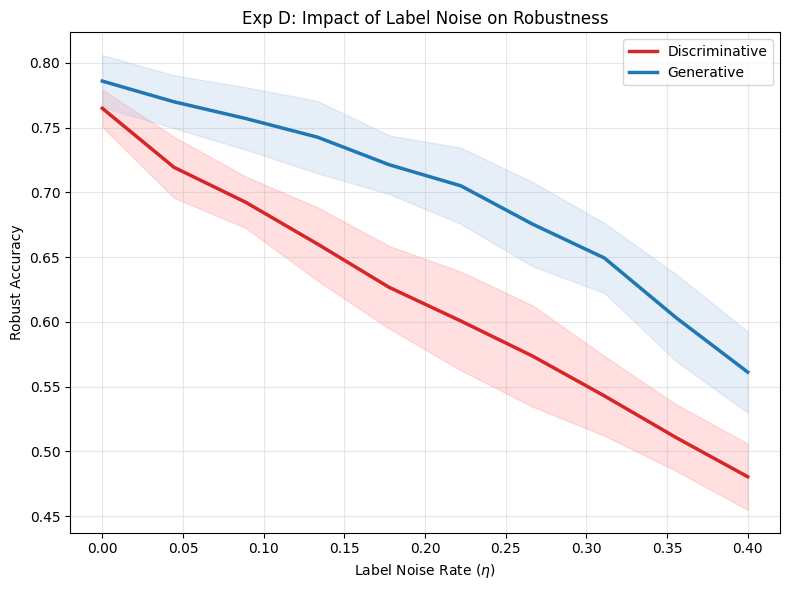

Experiments Complete. Results saved to: experiment_logs


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.metrics import accuracy_score
import pandas as pd
import os
import itertools
import seaborn as sns

# ==========================================
# 1. CONFIGURATION & HYPERPARAMETERS
# ==========================================
# Data Settings
D = 64
N_TRAIN = 400
N_TEST = 1000
BASE_NOISE = 0.15 # Default noise for Exp A, B, C

# Attack Settings
EPSILON = 0.2
PGD_STEPS = 7
PGD_ALPHA = 0.05

# Simulation Settings
N_SEEDS = 10      # Number of trials per point (Higher = Smoother)
SAVE_DIR = "experiment_logs"
os.makedirs(SAVE_DIR, exist_ok=True)

# Aesthetics
COLOR_DISC_MAIN = "#D62728" # Strong Red
COLOR_DISC_FILL = "#FF9896" # Light Red
COLOR_GEN_MAIN  = "#1F77B4" # Strong Blue
COLOR_GEN_FILL  = "#AEC7E8" # Light Blue

# ==========================================
# 2. CORE LOGIC (MODELS & DATA)
# ==========================================

def generate_data(n, d, sigma_scale=1.0, noise=0.0, seed=None):
    if seed is not None: np.random.seed(seed)

    if sigma_scale == 1.0:
        cov_diag = np.ones(d)
    else:
        # Anisotropic: High variance in noise directions
        cov_diag = np.linspace(1.0, sigma_scale, d)

    X = np.random.randn(n, d) * np.sqrt(cov_diag)
    beta = np.zeros(d); beta[0] = 1.0
    y = np.sign(X @ beta)

    if noise > 0:
        flip = np.random.rand(n) < noise
        y[flip] *= -1
    return X, y

def get_random_features(X, W):
    N = W.shape[0]
    Z = np.maximum(0, X @ W.T)
    return Z / np.sqrt(N)

def train_ridge(Phi, y, lam=1e-8):
    n, N = Phi.shape
    if N > n:
        K = Phi @ Phi.T
        K[np.diag_indices_from(K)] += lam
        try:
            alpha = scipy.linalg.solve(K, y, assume_a='pos')
        except scipy.linalg.LinAlgError:
            alpha = scipy.linalg.lstsq(K, y)[0]
        theta = Phi.T @ alpha
    else:
        Cov = Phi.T @ Phi
        Cov[np.diag_indices_from(Cov)] += lam
        try:
            theta = scipy.linalg.solve(Cov, Phi.T @ y, assume_a='pos')
        except:
            theta = scipy.linalg.lstsq(Cov, Phi.T @ y)[0]
    return theta

def train_generative(Phi, y):
    pos_mask = (y == 1); neg_mask = (y == -1)
    if np.sum(pos_mask) == 0: return -np.ones(Phi.shape[1])
    if np.sum(neg_mask) == 0: return np.ones(Phi.shape[1])
    mu_pos = np.mean(Phi[pos_mask], axis=0)
    mu_neg = np.mean(Phi[neg_mask], axis=0)
    return mu_pos - mu_neg

def pgd_attack(model_theta, W, X, y, epsilon, alpha, steps):
    N = W.shape[0]
    X_adv = X.copy()
    for _ in range(steps):
        Z_pre = X_adv @ W.T
        activations = (Z_pre > 0).astype(float)
        grad_x = (activations * model_theta[None, :]) @ W
        grad_x = grad_x / np.sqrt(N)
        step_dir = -y[:, None] * np.sign(grad_x)
        X_adv = X_adv + alpha * step_dir
        delta = X_adv - X
        norms = np.linalg.norm(delta, axis=1, keepdims=True)
        norms[norms < 1e-10] = 1.0
        factor = np.minimum(1, epsilon / norms)
        X_adv = X + (delta * factor)
    return X_adv

# ==========================================
# 3. ROBUST EXPERIMENT RUNNER (CSV LOGGING)
# ==========================================

def run_single_trial(N_features, lam_ridge, sigma_scale, noise_rate, seed):
    # Set seed for this specific trial
    np.random.seed(seed)

    # 1. Data
    X_train, y_train = generate_data(N_TRAIN, D, sigma_scale, noise=noise_rate)
    X_test, y_test   = generate_data(N_TEST, D, sigma_scale, noise=0.0) # Test always clean

    # 2. Features
    W = np.random.randn(N_features, D)
    Phi_train = get_random_features(X_train, W)
    Phi_test  = get_random_features(X_test, W)

    # 3. Models
    theta_A = train_ridge(Phi_train, y_train, lam=lam_ridge)
    theta_B = train_generative(Phi_train, y_train)

    # 4. Metrics
    # Norms
    norm_A = np.linalg.norm(theta_A)
    norm_B = np.linalg.norm(theta_B)

    # Standard Accuracy
    acc_A = accuracy_score(y_test, np.sign(Phi_test @ theta_A))
    acc_B = accuracy_score(y_test, np.sign(Phi_test @ theta_B))

    # Robust Accuracy
    X_adv_A = pgd_attack(theta_A, W, X_test, y_test, EPSILON, PGD_ALPHA, PGD_STEPS)
    rob_A   = accuracy_score(y_test, np.sign(get_random_features(X_adv_A, W) @ theta_A))

    X_adv_B = pgd_attack(theta_B, W, X_test, y_test, EPSILON, PGD_ALPHA, PGD_STEPS)
    rob_B   = accuracy_score(y_test, np.sign(get_random_features(X_adv_B, W) @ theta_B))

    return {
        'N': N_features, 'Lambda': lam_ridge, 'Sigma': sigma_scale, 'Noise': noise_rate, 'Seed': seed,
        'Acc_A': acc_A, 'Rob_A': rob_A, 'Norm_A': norm_A,
        'Acc_B': acc_B, 'Rob_B': rob_B, 'Norm_B': norm_B
    }

def execute_sweep(experiment_name, param_grid):
    filename = os.path.join(SAVE_DIR, f"{experiment_name}.csv")

    # Check what's already done
    completed_keys = set()
    if os.path.exists(filename):
        df_exist = pd.read_csv(filename)
        # Create a tuple key for each existing row to track progress
        keys = list(param_grid[0].keys()) # Extract column names from first grid item
        for _, row in df_exist.iterrows():
            # Create tuple of values for the defining parameters
            key = tuple([row[k] for k in keys if k in row])
            completed_keys.add(key)
    else:
        # Create file with headers if it doesn't exist
        dummy_res = run_single_trial(D, 1e-8, 1.0, 0.0, 0)
        pd.DataFrame([dummy_res]).iloc[0:0].to_csv(filename, index=False)

    print(f"--- Running {experiment_name} ---")
    print(f"Total Configs: {len(param_grid)} | Already Done: {len(completed_keys)}")

    for params in param_grid:
        # Construct key for checking
        current_key = tuple(params.values())
        if current_key in completed_keys:
            continue

        # Run
        try:
            result = run_single_trial(
                N_features=params['N'],
                lam_ridge=params['Lambda'],
                sigma_scale=params['Sigma'],
                noise_rate=params['Noise'],
                seed=params['Seed']
            )

            # Append to CSV immediately
            pd.DataFrame([result]).to_csv(filename, mode='a', header=False, index=False)
            print(f"Done: N={params['N']}, Seed={params['Seed']} -> RobA={result['Rob_A']:.2f}, RobB={result['Rob_B']:.2f}")
        except Exception as e:
            print(f"Error on {params}: {e}")

    return pd.read_csv(filename)

# ==========================================
# 4. EXPERIMENT DEFINITIONS
# ==========================================

def run_all_experiments():
    seeds = range(N_SEEDS)

    # --- EXP A: The Curse (Varying N) ---
    # Finer grid for smoother curves
    n_values = np.unique(np.logspace(np.log10(D), np.log10(2000), 20).astype(int))
    grid_A = [{'N': n, 'Lambda': 1e-6, 'Sigma': 1.0, 'Noise': BASE_NOISE, 'Seed': s}
              for n in n_values for s in seeds]
    df_A = execute_sweep("exp_A_curse", grid_A)

    # --- EXP B: The Tradeoff (Varying Lambda) ---
    lam_values = np.logspace(-6, 2, 15)
    grid_B = [{'N': 2000, 'Lambda': l, 'Sigma': 1.0, 'Noise': BASE_NOISE, 'Seed': s}
              for l in lam_values for s in seeds]
    df_B = execute_sweep("exp_B_pareto", grid_B)

    # --- EXP C: Hidden Cost (Anisotropic) ---
    grid_C = [{'N': n, 'Lambda': 1e-6, 'Sigma': 25.0, 'Noise': BASE_NOISE, 'Seed': s}
              for n in n_values for s in seeds]
    df_C = execute_sweep("exp_C_aniso", grid_C)

    # --- EXP D: Noise Sensitivity (Varying Noise Rate) ---
    # Checks if Generative is indeed better at handling higher noise
    noise_values = np.linspace(0.0, 0.4, 10)
    grid_D = [{'N': 2000, 'Lambda': 1e-6, 'Sigma': 1.0, 'Noise': nz, 'Seed': s}
              for nz in noise_values for s in seeds]
    df_D = execute_sweep("exp_D_noise", grid_D)

    return df_A, df_B, df_C, df_D

# ==========================================
# 5. PLOTTING FUNCTIONS
# ==========================================

def plot_with_error_bars(ax, df, x_col, y_col_mean, label, color_main, color_fill, linestyle='-'):
    # Group by the x-axis variable
    grouped = df.groupby(x_col)[y_col_mean].agg(['mean', 'std']).reset_index()

    x = grouped[x_col]
    mu = grouped['mean']
    sigma = grouped['std']

    ax.plot(x, mu, color=color_main, label=label, linewidth=2.5, linestyle=linestyle)
    ax.fill_between(x, mu - sigma, mu + sigma, color=color_fill, alpha=0.3)

def generate_plots(df_A, df_B, df_C, df_D):
    # Calculate Ratio for plots
    df_A['Ratio'] = df_A['N'] / N_TRAIN
    df_C['Ratio'] = df_C['N'] / N_TRAIN

    # --- FIGURE 1: The Curse (Robustness & Norm) ---
    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax2 = ax1.twinx()

    plot_with_error_bars(ax1, df_A, 'Ratio', 'Rob_A', 'Discriminative (Ridge)', COLOR_DISC_MAIN, COLOR_DISC_FILL)
    plot_with_error_bars(ax1, df_A, 'Ratio', 'Rob_B', 'Generative (Centroid)', COLOR_GEN_MAIN, COLOR_GEN_FILL)

    # Plot Norms on secondary axis (Dashed)
    # We aggregate manually for norms to handle log scale visual
    gA = df_A.groupby('Ratio')['Norm_A'].mean()
    gB = df_A.groupby('Ratio')['Norm_B'].mean()

    l3 = ax2.plot(gA.index, gA, color=COLOR_DISC_MAIN, linestyle='--', alpha=0.6, label='Discrim. Norm')
    l4 = ax2.plot(gB.index, gB, color=COLOR_GEN_MAIN, linestyle='--', alpha=0.6, label='Generative Norm')

    ax1.set_xlabel('Overparametrization Ratio ($N/n$)')
    ax1.set_ylabel('Robust Accuracy', fontweight='bold')
    ax2.set_ylabel('Weight Norm $\|\Theta\|_2$', rotation=270, labelpad=20)
    ax2.set_yscale('log')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='lower left')
    ax2.legend(loc='center right')
    plt.title('Exp A: The Curse of Overparametrization')
    plt.tight_layout()
    plt.show()

    # --- FIGURE 2: Pareto Frontier ---
    plt.figure(figsize=(8, 6))

    # Discrim Curve
    g_B = df_B.groupby('Lambda')[['Acc_A', 'Rob_A']].mean().reset_index()
    plt.plot(g_B['Acc_A'], g_B['Rob_A'], color=COLOR_DISC_MAIN, marker='o', label='Discriminative (Varying $\lambda$)')

    # Generative Point (Mean +- Std)
    gen_acc_mean = df_B['Acc_B'].mean()
    gen_acc_std = df_B['Acc_B'].std()
    gen_rob_mean = df_B['Rob_B'].mean()
    gen_rob_std = df_B['Rob_B'].std()

    plt.errorbar(gen_acc_mean, gen_rob_mean, xerr=gen_acc_std, yerr=gen_rob_std,
                 fmt='o', color=COLOR_GEN_MAIN, markersize=10, label='Generative (Fixed)', capsize=5)

    plt.xlabel('Standard Accuracy')
    plt.ylabel('Robust Accuracy')
    plt.title('Exp B: Accuracy vs. Robustness Trade-off')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- FIGURE 3: Hidden Cost ---
    plt.figure(figsize=(8, 6))
    plot_with_error_bars(plt.gca(), df_C, 'Ratio', 'Acc_A', 'Discriminative', COLOR_DISC_MAIN, COLOR_DISC_FILL)
    plot_with_error_bars(plt.gca(), df_C, 'Ratio', 'Acc_B', 'Generative', COLOR_GEN_MAIN, COLOR_GEN_FILL)
    plt.xlabel('Overparametrization Ratio ($N/n$)')
    plt.ylabel('Standard Accuracy')
    plt.title('Exp C: Performance on Anisotropic Data')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- FIGURE 4: Noise Sensitivity (New) ---
    plt.figure(figsize=(8, 6))
    plot_with_error_bars(plt.gca(), df_D, 'Noise', 'Rob_A', 'Discriminative', COLOR_DISC_MAIN, COLOR_DISC_FILL)
    plot_with_error_bars(plt.gca(), df_D, 'Noise', 'Rob_B', 'Generative', COLOR_GEN_MAIN, COLOR_GEN_FILL)
    plt.xlabel('Label Noise Rate ($\eta$)')
    plt.ylabel('Robust Accuracy')
    plt.title('Exp D: Impact of Label Noise on Robustness')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Run all
    df_A, df_B, df_C, df_D = run_all_experiments()

    # Generate plots
    generate_plots(df_A, df_B, df_C, df_D)

    print("Experiments Complete. Results saved to:", SAVE_DIR)

Running Exp E (Adversarial Training Comparison) - 10 seeds...
Seed 0 N=256: Std=0.58, Gen=0.69, AT=0.64
Seed 0 N=614: Std=0.54, Gen=0.70, AT=0.39
Seed 0 N=972: Std=0.58, Gen=0.73, AT=0.38
Seed 0 N=1331: Std=0.59, Gen=0.73, AT=0.42
Seed 0 N=1689: Std=0.64, Gen=0.74, AT=0.50
Seed 0 N=2048: Std=0.65, Gen=0.74, AT=0.46
Seed 1 N=256: Std=0.55, Gen=0.69, AT=0.59
Seed 1 N=614: Std=0.52, Gen=0.73, AT=0.40
Seed 1 N=972: Std=0.59, Gen=0.70, AT=0.37
Seed 1 N=1331: Std=0.62, Gen=0.76, AT=0.43
Seed 1 N=1689: Std=0.64, Gen=0.76, AT=0.47
Seed 1 N=2048: Std=0.65, Gen=0.75, AT=0.46
Seed 2 N=256: Std=0.54, Gen=0.68, AT=0.58
Seed 2 N=614: Std=0.49, Gen=0.70, AT=0.42
Seed 2 N=972: Std=0.56, Gen=0.69, AT=0.43
Seed 2 N=1331: Std=0.59, Gen=0.72, AT=0.44
Seed 2 N=1689: Std=0.59, Gen=0.72, AT=0.43
Seed 2 N=2048: Std=0.58, Gen=0.74, AT=0.48
Seed 3 N=256: Std=0.55, Gen=0.74, AT=0.59
Seed 3 N=614: Std=0.52, Gen=0.72, AT=0.41
Seed 3 N=972: Std=0.61, Gen=0.73, AT=0.39
Seed 3 N=1331: Std=0.61, Gen=0.72, AT=0.40
Seed

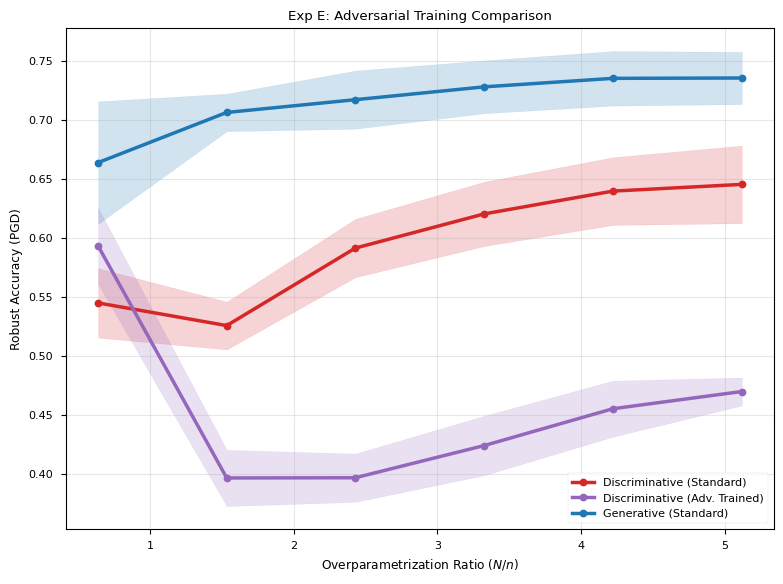

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns

# ==========================================
# 1. CONFIGURATION
# ==========================================
D = 64           # Input dimension
N_TRAIN = 400    # Training samples
N_TEST = 1000    # Test samples
BASE_NOISE = 0.15 # Label noise (triggers the curse)

# Attack Settings
EPSILON = 0.2
PGD_STEPS = 7
PGD_ALPHA = 0.05
N_SEEDS = 10      # Number of trials for error bars

# Plotting Style
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({'font.size': 12, 'lines.linewidth': 2.5})

# ==========================================
# 2. HELPER FUNCTIONS (Data & Training)
# ==========================================

def generate_data(n, d, sigma_scale=1.0, noise=0.0):
    if sigma_scale == 1.0: cov = np.ones(d)
    else: cov = np.linspace(1.0, sigma_scale, d)
    X = np.random.randn(n, d) * np.sqrt(cov)
    beta = np.zeros(d); beta[0] = 1.0
    y = np.sign(X @ beta)
    if noise > 0: y[np.random.rand(n) < noise] *= -1
    return X, y

def get_random_features(X, W):
    N = W.shape[0]
    Z = np.maximum(0, X @ W.T)
    return Z / np.sqrt(N)

def train_ridge(Phi, y, lam=1e-6):
    """Discriminative Solver"""
    n, N = Phi.shape
    if N > n:
        K = Phi @ Phi.T; K[np.diag_indices_from(K)] += lam
        try: alpha = scipy.linalg.solve(K, y, assume_a='pos')
        except: alpha = scipy.linalg.lstsq(K, y)[0]
        return Phi.T @ alpha
    else:
        Cov = Phi.T @ Phi; Cov[np.diag_indices_from(Cov)] += lam
        try: theta = scipy.linalg.solve(Cov, Phi.T @ y, assume_a='pos')
        except: theta = scipy.linalg.lstsq(Cov, Phi.T @ y)[0]
    return theta

def train_generative(Phi, y):
    """Generative Solver (Centroids)"""
    pos_mask = (y == 1); neg_mask = (y == -1)
    if np.sum(pos_mask) == 0: return -np.ones(Phi.shape[1])
    if np.sum(neg_mask) == 0: return np.ones(Phi.shape[1])
    return np.mean(Phi[pos_mask], axis=0) - np.mean(Phi[neg_mask], axis=0)

def pgd_attack(model_theta, W, X, y, epsilon, alpha, steps):
    """PGD Attack generator"""
    N = W.shape[0]
    X_adv = X.copy()
    for _ in range(steps):
        Z_pre = X_adv @ W.T
        activations = (Z_pre > 0).astype(float)
        grad_x = (activations * model_theta[None, :]) @ W / np.sqrt(N)
        step_dir = -y[:, None] * np.sign(grad_x) # Minimize margin
        X_adv = X_adv + alpha * step_dir

        delta = X_adv - X
        norms = np.linalg.norm(delta, axis=1, keepdims=True) + 1e-10
        X_adv = X + delta * np.minimum(1, epsilon / norms)
    return X_adv

# ==========================================
# 3. EXPERIMENT E LOGIC
# ==========================================

def run_experiment_E(n_seeds=N_SEEDS):
    print(f"Running Exp E (Adversarial Training Comparison) - {n_seeds} seeds...")

    # Focus on the Overparametrized Regime where the Curse happens
    N_values = np.linspace(256, 2048, 6).astype(int)
    results = []

    for seed in range(n_seeds):
        np.random.seed(seed)
        # 1. Data Generation
        X_tr, y_tr = generate_data(N_TRAIN, D, noise=BASE_NOISE)
        X_te, y_te = generate_data(N_TEST, D, noise=0.0)

        for N in N_values:
            W = np.random.randn(N, D)
            Phi_tr = get_random_features(X_tr, W)
            Phi_te = get_random_features(X_te, W)

            # --- Model 1: Standard Discriminative (Ridge) ---
            th_std = train_ridge(Phi_tr, y_tr, lam=1e-6)

            # --- Model 2: Generative (Centroid) ---
            th_gen = train_generative(Phi_tr, y_tr)

            # --- Model 3: Adversarial Training (Ridge + AT) ---
            # Step A: Attack the training data using the standard model
            # We must attack X_tr (input space) using the current theta
            X_tr_adv = pgd_attack(th_std, W, X_tr, y_tr, EPSILON, PGD_ALPHA, PGD_STEPS)
            Phi_tr_adv = get_random_features(X_tr_adv, W)

            # Step B: Train on mixture (Clean + Adversarial)
            # This is "Data Augmentation" style AT, standard for linear models
            Phi_combined = np.vstack([Phi_tr, Phi_tr_adv])
            y_combined = np.hstack([y_tr, y_tr])

            th_at = train_ridge(Phi_combined, y_combined, lam=1e-6)

            # --- EVALUATION (Robust Accuracy on Test Set) ---
            # Attack Standard Model
            X_adv_std = pgd_attack(th_std, W, X_te, y_te, EPSILON, PGD_ALPHA, PGD_STEPS)
            rob_std = accuracy_score(y_te, np.sign(get_random_features(X_adv_std, W) @ th_std))

            # Attack Generative Model
            X_adv_gen = pgd_attack(th_gen, W, X_te, y_te, EPSILON, PGD_ALPHA, PGD_STEPS)
            rob_gen = accuracy_score(y_te, np.sign(get_random_features(X_adv_gen, W) @ th_gen))

            # Attack AT Model
            X_adv_at = pgd_attack(th_at, W, X_te, y_te, EPSILON, PGD_ALPHA, PGD_STEPS)
            rob_at = accuracy_score(y_te, np.sign(get_random_features(X_adv_at, W) @ th_at))

            results.append({
                'Ratio': N/N_TRAIN,
                'Rob_Standard': rob_std,
                'Rob_Generative': rob_gen,
                'Rob_AT': rob_at
            })

            print(f"Seed {seed} N={N}: Std={rob_std:.2f}, Gen={rob_gen:.2f}, AT={rob_at:.2f}")

    return pd.DataFrame(results)

# ==========================================
# 4. PLOTTING
# ==========================================

def plot_experiment_E(df):
    plt.figure(figsize=(8, 6))

    # Colors
    c_std = '#D62728' # Red
    c_gen = '#1F77B4' # Blue
    c_at  = '#9467BD' # Purple

    # Helper to plot with bands
    def plot_band(col_name, label, color):
        grp = df.groupby('Ratio')[col_name].agg(['mean', 'std']).reset_index()
        plt.plot(grp['Ratio'], grp['mean'], label=label, color=color, marker='o', linewidth=2.5)
        plt.fill_between(grp['Ratio'], grp['mean']-grp['std'], grp['mean']+grp['std'], color=color, alpha=0.2)

    plot_band('Rob_Standard', 'Discriminative (Standard)', c_std)
    plot_band('Rob_AT', 'Discriminative (Adv. Trained)', c_at)
    plot_band('Rob_Generative', 'Generative (Standard)', c_gen)

    plt.xlabel('Overparametrization Ratio ($N/n$)')
    plt.ylabel('Robust Accuracy (PGD)')
    plt.title('Exp E: Adversarial Training Comparison')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    df_E = run_experiment_E()
    print("\n--- Results Summary (Mean) ---")
    print(df_E.groupby('Ratio').mean())
    plot_experiment_E(df_E)

In [14]:
!pip install transformers datasets torch torchvision scikit-learn matplotlib pandas seaborn


Running on cuda
Loading MNIST...

--- Running Exp F: MNIST ---
N=64: Rob[R/G/L] = 0.63 / 0.65 / 0.41
N=256: Rob[R/G/L] = 0.06 / 0.99 / 0.17
N=512: Rob[R/G/L] = 0.02 / 0.98 / 0.43
N=1024: Rob[R/G/L] = 0.01 / 0.97 / 0.28
N=2048: Rob[R/G/L] = 0.02 / 0.91 / 0.38
N=4096: Rob[R/G/L] = 0.04 / 0.90 / 0.36
N=64: Rob[R/G/L] = 0.68 / 0.60 / 0.57
N=256: Rob[R/G/L] = 0.05 / 0.93 / 0.46
N=512: Rob[R/G/L] = 0.02 / 0.86 / 0.51
N=1024: Rob[R/G/L] = 0.01 / 0.86 / 0.46
N=2048: Rob[R/G/L] = 0.04 / 0.91 / 0.37
N=4096: Rob[R/G/L] = 0.06 / 0.87 / 0.57
N=64: Rob[R/G/L] = 0.68 / 0.92 / 0.42
N=256: Rob[R/G/L] = 0.05 / 0.93 / 0.50
N=512: Rob[R/G/L] = 0.01 / 0.95 / 0.42
N=1024: Rob[R/G/L] = 0.02 / 0.76 / 0.57
N=2048: Rob[R/G/L] = 0.03 / 0.87 / 0.51
N=4096: Rob[R/G/L] = 0.06 / 0.91 / 0.37
N=64: Rob[R/G/L] = 0.57 / 0.87 / 0.43
N=256: Rob[R/G/L] = 0.06 / 0.71 / 0.42
N=512: Rob[R/G/L] = 0.02 / 0.93 / 0.38
N=1024: Rob[R/G/L] = 0.02 / 0.85 / 0.57
N=2048: Rob[R/G/L] = 0.04 / 0.92 / 0.52
N=4096: Rob[R/G/L] = 0.06 / 0.92 

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting: 100%|██████████| 32/32 [00:02<00:00, 12.32it/s]



--- Running Exp F: CIFAR ---
N=64: Rob[R/G/L] = 0.39 / 0.50 / 0.47
N=256: Rob[R/G/L] = 0.22 / 0.61 / 0.51
N=512: Rob[R/G/L] = 0.16 / 0.69 / 0.49
N=1024: Rob[R/G/L] = 0.18 / 0.66 / 0.34
N=2048: Rob[R/G/L] = 0.29 / 0.73 / 0.38
N=4096: Rob[R/G/L] = 0.29 / 0.72 / 0.49
N=64: Rob[R/G/L] = 0.36 / 0.50 / 0.50
N=256: Rob[R/G/L] = 0.24 / 0.59 / 0.49
N=512: Rob[R/G/L] = 0.14 / 0.60 / 0.48
N=1024: Rob[R/G/L] = 0.18 / 0.70 / 0.49
N=2048: Rob[R/G/L] = 0.28 / 0.72 / 0.49
N=4096: Rob[R/G/L] = 0.27 / 0.74 / 0.37
N=64: Rob[R/G/L] = 0.40 / 0.50 / 0.46
N=256: Rob[R/G/L] = 0.26 / 0.65 / 0.43
N=512: Rob[R/G/L] = 0.13 / 0.69 / 0.49
N=1024: Rob[R/G/L] = 0.22 / 0.64 / 0.37
N=2048: Rob[R/G/L] = 0.28 / 0.72 / 0.41
N=4096: Rob[R/G/L] = 0.30 / 0.76 / 0.39
N=64: Rob[R/G/L] = 0.37 / 0.49 / 0.37
N=256: Rob[R/G/L] = 0.27 / 0.64 / 0.38
N=512: Rob[R/G/L] = 0.15 / 0.71 / 0.45
N=1024: Rob[R/G/L] = 0.20 / 0.67 / 0.37
N=2048: Rob[R/G/L] = 0.25 / 0.66 / 0.49
N=4096: Rob[R/G/L] = 0.33 / 0.74 / 0.42
N=64: Rob[R/G/L] = 0.44 / 

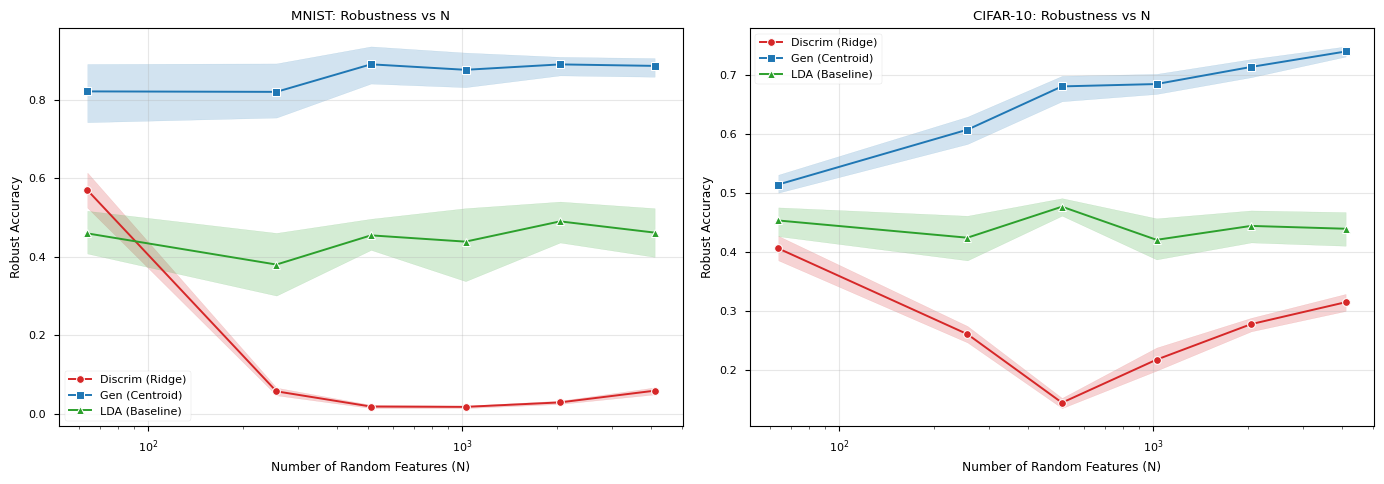


--- SUMMARY TABLE (Means) ---

MNIST:
       Rob_R      Norm_R   Rob_G    Norm_G   Rob_L     Norm_L
N                                                            
64    0.5698    6.486342  0.8212  6.131455  0.4594   2.258316
256   0.0570   52.891086  0.8200  5.822315  0.3800   9.184429
512   0.0182  345.241457  0.8902  6.068574  0.4544  14.298942
1024  0.0174   22.191765  0.8762  6.031694  0.4384  18.124467
2048  0.0288   16.505792  0.8900  6.003010  0.4900  19.831390
4096  0.0586   14.665529  0.8862  5.997427  0.4614  20.833338

CIFAR-10:
       Rob_R      Norm_R   Rob_G    Norm_G   Rob_L     Norm_L
N                                                            
64    0.4062    7.091653  0.5146  1.441126  0.4536   2.219006
256   0.2608   65.875058  0.6076  1.552332  0.4244   8.280141
512   0.1446  270.247508  0.6810  1.554774  0.4770  16.728584
1024  0.2176    9.256420  0.6850  1.530227  0.4208  25.322151
2048  0.2778    7.067472  0.7140  1.522325  0.4444  29.901155
4096  0.3150    6.36

In [17]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# ==========================================
# 1. CONFIGURATION
# ==========================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}")

# Settings
N_TRAIN = 500
N_TEST = 500
NOISE_RATE = 0.20 # 20% Label Noise
EPSILON = 0.5     # L2 Norm Budget
N_SEEDS = 10       # Number of trials

# Overparametrization Sweep
N_VALUES = [64, 256, 512, 1024, 2048, 4096]

# Plotting Styles
COLORS = {'Ridge': '#D62728', 'Gen': '#1F77B4', 'LDA': '#2CA02C'} # Red, Blue, Green
plt.style.use('seaborn-v0_8-paper')

# ==========================================
# 2. FEATURE EXTRACTION
# ==========================================

def get_mnist_features():
    print("Loading MNIST...")
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    ds_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    ds_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    def process(ds):
        # Filter 0 vs 1
        idx = (ds.targets == 0) | (ds.targets == 1)
        X = ds.data[idx].float().view(-1, 784) / 255.0
        X = (X - 0.5) * 2.0
        y = ds.targets[idx]
        y = torch.where(y == 0, torch.tensor(-1), torch.tensor(1)).numpy()
        return X.numpy(), y

    X_tr, y_tr = process(ds_train)
    X_te, y_te = process(ds_test)
    return X_tr[:N_TRAIN], y_tr[:N_TRAIN], X_te[:N_TEST], y_te[:N_TEST]

def get_cifar_features():
    print("Loading CIFAR-10 (ResNet-18)...")
    model = torchvision.models.resnet18(pretrained=True)
    model.fc = nn.Identity()
    model.to(DEVICE)
    model.eval()

    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    ds_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    ds_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    def extract(ds):
        # Cats (3) vs Dogs (5)
        indices = [i for i, t in enumerate(ds.targets) if t in [3, 5]]
        if len(indices) > N_TRAIN + N_TEST: indices = indices[:N_TRAIN+N_TEST]

        loader = torch.utils.data.DataLoader(torch.utils.data.Subset(ds, indices), batch_size=32)
        feats, labels = [], []
        with torch.no_grad():
            for x, y in tqdm(loader, desc="Extracting"):
                x = x.to(DEVICE)
                f = model(x).cpu().numpy()
                feats.append(f)
                labels.append(y.numpy())
        X = np.vstack(feats)
        y = np.hstack(labels)
        y = np.where(y == 3, -1, 1)
        return X, y

    X, y = extract(ds_train)
    return X[:N_TRAIN], y[:N_TRAIN], X[N_TRAIN:N_TRAIN+N_TEST], y[N_TRAIN:N_TRAIN+N_TEST]

# ==========================================
# 3. TRAINING & ATTACK
# ==========================================

def get_random_features(X, W):
    # Normalize input for stability
    X_norm = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-8) * np.sqrt(X.shape[1])
    Z = np.maximum(0, X_norm @ W.T)
    return Z / np.sqrt(W.shape[0])

def train_ridge(Phi, y, lam=1e-5):
    n, N = Phi.shape
    if N > n:
        K = Phi @ Phi.T; K[np.diag_indices_from(K)] += lam
        try: alpha = scipy.linalg.solve(K, y, assume_a='pos')
        except: alpha = scipy.linalg.lstsq(K, y)[0]
        return Phi.T @ alpha
    else:
        Cov = Phi.T @ Phi; Cov[np.diag_indices_from(Cov)] += lam
        try: theta = scipy.linalg.solve(Cov, Phi.T @ y, assume_a='pos')
        except: theta = scipy.linalg.lstsq(Cov, Phi.T @ y)[0]
    return theta

def train_generative(Phi, y):
    # Nearest Centroid
    pos = Phi[y==1]; neg = Phi[y==-1]
    if len(pos) == 0 or len(neg) == 0: return np.zeros(Phi.shape[1])
    return np.mean(pos, axis=0) - np.mean(neg, axis=0)

def train_lda(Phi, y, lam=1e-2):
    # LDA: Theta = Sigma^-1 (mu_+ - mu_-)
    pos = Phi[y==1]; neg = Phi[y==-1]
    if len(pos) == 0 or len(neg) == 0: return np.zeros(Phi.shape[1])

    mu_pos = np.mean(pos, axis=0)
    mu_neg = np.mean(neg, axis=0)
    diff = mu_pos - mu_neg

    # Pooled Covariance
    Phi_c = Phi.copy()
    Phi_c[y==1] -= mu_pos
    Phi_c[y==-1] -= mu_neg
    Sigma = (Phi_c.T @ Phi_c) / (len(y) - 2)
    Sigma[np.diag_indices_from(Sigma)] += lam # Regularize

    try: theta = scipy.linalg.solve(Sigma, diff, assume_a='pos')
    except: theta = scipy.linalg.lstsq(Sigma, diff)[0]
    return theta

def auto_attack(model_theta, W, X, y, epsilon, steps=7):
    # PGD on Raw Input
    X_scale = np.sqrt(X.shape[1])
    X_adv = X.copy()
    N = W.shape[0]
    alpha = epsilon / steps * 1.5

    for _ in range(steps):
        # 1. Forward to get Gradient direction
        # Approx gradient through normalization and ReLU
        # Grad ~ W^T * diag(activity) * theta

        norms = np.linalg.norm(X_adv, axis=1, keepdims=True) + 1e-8
        X_norm = X_adv / norms * X_scale

        activations = ((X_norm @ W.T) > 0).astype(float)
        grad_x = (activations * model_theta[None, :]) @ W / np.sqrt(N)

        # 3. Update (Minimize margin -> Move against y*grad)
        X_adv = X_adv - alpha * y[:, None] * np.sign(grad_x)

        # 4. Project
        delta = X_adv - X
        d_norms = np.linalg.norm(delta, axis=1, keepdims=True) + 1e-8
        factor = np.minimum(1, epsilon / d_norms)
        X_adv = X + delta * factor

    return X_adv

# ==========================================
# 4. EXPERIMENT F RUNNER
# ==========================================

def run_experiment_F(dataset_name, n_seeds=N_SEEDS):
    if dataset_name == 'MNIST': X_tr, y_tr, X_te, y_te = get_mnist_features()
    elif dataset_name == 'CIFAR': X_tr, y_tr, X_te, y_te = get_cifar_features()

    d_raw = X_tr.shape[1]
    results = []

    print(f"\n--- Running Exp F: {dataset_name} ---")

    for seed in range(n_seeds):
        np.random.seed(seed)

        # Inject Noise
        y_tr_noisy = y_tr.copy()
        noise_idx = np.random.choice(len(y_tr), int(NOISE_RATE * len(y_tr)), replace=False)
        y_tr_noisy[noise_idx] *= -1

        for N in N_VALUES:
            W = np.random.randn(N, d_raw)
            Phi_tr = get_random_features(X_tr, W)
            Phi_te = get_random_features(X_te, W)

            # Train 3 Models
            th_R = train_ridge(Phi_tr, y_tr_noisy)
            th_G = train_generative(Phi_tr, y_tr_noisy)
            th_L = train_lda(Phi_tr, y_tr_noisy)

            # Attack 3 Models
            # Ridge
            X_adv = auto_attack(th_R, W, X_te, y_te, EPSILON)
            rob_R = accuracy_score(y_te, np.sign(get_random_features(X_adv, W) @ th_R))

            # Generative
            X_adv = auto_attack(th_G, W, X_te, y_te, EPSILON)
            rob_G = accuracy_score(y_te, np.sign(get_random_features(X_adv, W) @ th_G))

            # LDA
            X_adv = auto_attack(th_L, W, X_te, y_te, EPSILON)
            rob_L = accuracy_score(y_te, np.sign(get_random_features(X_adv, W) @ th_L))

            results.append({
                'Dataset': dataset_name, 'N': N, 'Ratio': N/N_TRAIN,
                'Rob_R': rob_R, 'Norm_R': np.linalg.norm(th_R),
                'Rob_G': rob_G, 'Norm_G': np.linalg.norm(th_G),
                'Rob_L': rob_L, 'Norm_L': np.linalg.norm(th_L)
            })
            print(f"N={N}: Rob[R/G/L] = {rob_R:.2f} / {rob_G:.2f} / {rob_L:.2f}")

    return pd.DataFrame(results)

if __name__ == "__main__":
    df_mnist = run_experiment_F('MNIST')
    df_cifar = run_experiment_F('CIFAR')

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    datasets = [('MNIST', df_mnist), ('CIFAR-10', df_cifar)]

    for ax, (name, df) in zip(axes, datasets):
        sns.lineplot(data=df, x='N', y='Rob_R', ax=ax, label='Discrim (Ridge)', color=COLORS['Ridge'], marker='o')
        sns.lineplot(data=df, x='N', y='Rob_G', ax=ax, label='Gen (Centroid)', color=COLORS['Gen'], marker='s')
        sns.lineplot(data=df, x='N', y='Rob_L', ax=ax, label='LDA (Baseline)', color=COLORS['LDA'], marker='^')

        ax.set_title(f"{name}: Robustness vs N")
        ax.set_xlabel('Number of Random Features (N)')
        ax.set_ylabel('Robust Accuracy')
        ax.set_xscale('log')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary Table
    print("\n--- SUMMARY TABLE (Means) ---")
    for name, df in datasets:
        print(f"\n{name}:")
        print(df.groupby('N')[['Rob_R', 'Norm_R', 'Rob_G', 'Norm_G', 'Rob_L', 'Norm_L']].mean())